# Import libraries and modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [6]:
from data_preprocess import preprocess
from preprocess_dental import preprocess_dental_data

# Load and preprocess data

In [8]:
df_dental = preprocess_dental_data()
df_data = preprocess()

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13772 entries, 0 to 13771
Columns: 214 entries, SEQN to OTHER_NON_CARIOUS_ROOT_LESION
dtypes: category(30), float64(184)
memory usage: 20.3 MB


In [ ]:
df_dental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13772 entries, 0 to 13771
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   SEQN                            13772 non-null  float64
 1   ANTERIOR_TOOTH_COUNT            13772 non-null  float64
 2   POSTERIOR_TOOTH_COUNT           13772 non-null  float64
 3   ANTERIOR_CARIES_COUNT           13772 non-null  float64
 4   POSTERIOR_CARIES_COUNT          13772 non-null  float64
 5   ANTERIOR_DENTAL_SEALANT_COUNT   13772 non-null  float64
 6   POSTERIOR_DENTAL_SEALANT_COUNT  13772 non-null  float64
 7   ROOT_CARIES                     13772 non-null  float64
 8   OTHER_NON_CARIOUS_ROOT_LESION   13772 non-null  float64
dtypes: float64(9)
memory usage: 968.5 KB


## Load Column descriptions

In [ ]:
def load_codenames(file_path):
  """
  Loads a file containing the descriptions of codes
  and returns a dictionary
  """
  with open(file_path, "r") as f:
    s = f.readlines()

  codedict = dict()
  for l in s:
    l = l[:-1]
    lt = l.split("-")
    codedict[lt[0].strip()] = " ".join(lt[1:]).strip()
  return codedict

In [ ]:
dental_codes = load_codenames("dataset/dentalcodenames.txt")
diet_codes = load_codenames("dataset/dietarycodenames.txt")
nutr_codes = load_codenames("dataset/nutritionalcodenames.txt")
all_codes = load_codenames("dataset/codenames.txt")

for i in df_dental.columns:
  dental_codes[i] = i.replace("_", " ")
  all_codes[i] = i.replace("_", " ")

In [1]:
def check_which_data(c):
  """
  Checks which dataset a particular column is from
  """
  if c in diet_codes:
    return "diet"
  if c in dental_codes:
    return "dental"
  if c in nutr_codes:
    return "nutrition"

# Cross dataset correlation

## Correlations between pairs of continous variables

<BarContainer object of 9 artists>

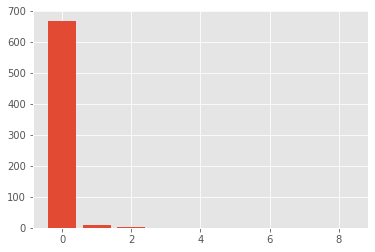

In [ ]:
df_corr = df_data.drop(columns = ["SEQN"]).corr(method = "spearman")
dfs = df_corr.stack()

corr_count = dict()
for corr in range(1, 10):
  corr_count[corr/10] = 0
  for a, v in zip(dfs.index, dfs):
    c1 = a[0]
    c2 = a[1]
    if c1 == c2 or check_which_data(c1) ==  check_which_data(c2) or abs(v) <corr/10:
      continue  
    corr_count[corr/10] += 1

plt.bar(np.arange(9), pd.Series(corr_count).values/2)

In [ ]:
print(corr_count)

{0.1: 1336, 0.2: 18, 0.3: 2, 0.4: 0, 0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 0}


In [ ]:
c = 0
for i, (a, v) in enumerate(zip(dfs.index, dfs)):
  if i > len(dfs)/2:
    break
  c1 = a[0]
  c2 = a[1]
  if c1 == c2 or check_which_data(c1) ==  check_which_data(c2) or abs(v) <0.22:
    continue  
  print(all_codes[c1], "(",c1,")-", check_which_data(c1), "is correlated with", all_codes[c2], "(",c2,")-",check_which_data(c2), "---",v)
  c += 1
print(c)

Total # of Dietary Supplements Taken ( DSDCOUNT )- diet is correlated with Number of foods/beverages reported ( DR1TNUMF )- nutrition --- 0.2308343099006234
Total # of Dietary Supplements Taken ( DSDCOUNT )- diet is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.25023287256478755
Calcium (mg) ( DSQTCALC )- diet is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.2516762159546641
Magnesium (mg) ( DSQTMAGN )- diet is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.2309082596469845
Number of foods/beverages reported ( DR1TNUMF )- nutrition is correlated with Total # of Dietary Supplements Taken ( DSDCOUNT )- diet --- 0.2308343099006234
Caffeine (mg) ( DR1TCAFF )- nutrition is correlated with ANTERIOR CARIES COUNT ( ANTERIOR_CARIES_COUNT )- dental --- 0.2284445216299341
Caffeine (mg) ( DR1TCAFF )- nutrition is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.316604

Caffiene is correlated with both anteriour and posterior caries, that is expected.

## Insights via grouping continous variables according to categorical variables

In [ ]:
dfgd = df_data.drop(columns = ["SEQN"]).groupby("DR1LANG").describe()

Text(0.5, 1.0, 'Mean (in gm) Caffeine consumptions of\ndifferent Language speaking groups')

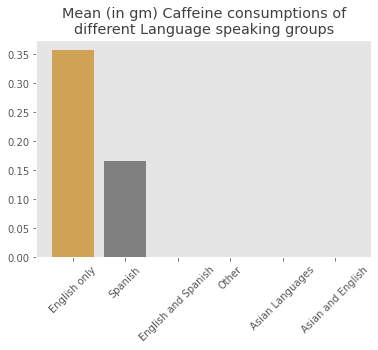

In [ ]:
num_bars = 9
x = dfgd[("DSQTCAFF", "mean")].index.values
y = dfgd[("DSQTCAFF", "mean")].values
# y.extend(count[0:7]) 
x_label=["English only", "Spanish", "English and Spanish", "Other", "Asian Languages", "Asian and English"]
colors = [plt.get_cmap('BrBG')(0.25), 'grey'] + [plt.get_cmap('BrBG')(0.25)] * 7
plt.xticks(x, x_label, rotation = 45)
plt.bar(x,y, color=colors)
plt.grid(False)
plt.title('Mean (in gm) Caffeine consumptions of\ndifferent Language speaking groups', color=plt.get_cmap('Greys')(0.8))

In [ ]:
dfgg = df_data.drop(columns = ["SEQN"]).groupby(["DSD010", "DR1MRESP"]).size()
a = []
for i in range (1, 12):
  if i == 4:
    continue
  a.append(dfgg[(2, i)])
a = np.array(a)/df_data.drop(columns = ["SEQN"]).groupby("DR1MRESP").count()["DSDCOUNT"].values

Text(0.5, 1.0, '% distribution of respondents who take supplements')

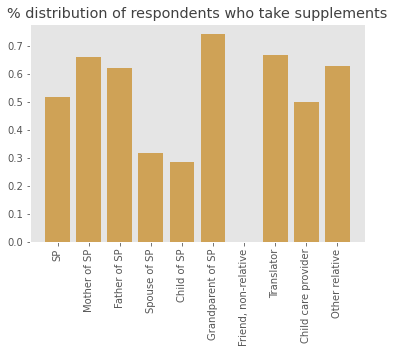

In [ ]:
y = a
x = np.arange(1, len(y)+1)
num_bars = len(x)
# y.extend(count[0:7]) 
x_label=['SP',
 'Mother of SP',
 'Father of SP',
 'Spouse of SP',
 'Child of SP',
 'Grandparent of SP',
 'Friend, non-relative',
 'Translator',
 'Child care provider',
 'Other relative']
colors = [plt.get_cmap('BrBG')(0.25)] * len(x)
plt.xticks(x, x_label, rotation = 90)
plt.bar(x,y, color=colors)
plt.grid(False)
plt.title('% distribution of respondents who take supplements', color=plt.get_cmap('Greys')(0.8))

In [ ]:
dfgd = df_data.drop(columns = ["SEQN"]).groupby("DR1MRESP").describe()

Text(0.5, 1.0, 'Mean (in mg) Phosphorous Supplements taken')

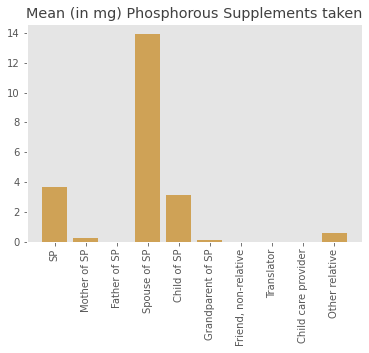

In [ ]:
y = dfgd[("DSQTPHOS", "mean")].values
x = np.arange(1, len(y)+1)
num_bars = len(x)
# y.extend(count[0:7]) 
x_label=['SP',
 'Mother of SP',
 'Father of SP',
 'Spouse of SP',
 'Child of SP',
 'Grandparent of SP',
 'Friend, non-relative',
 'Translator',
 'Child care provider',
 'Other relative']
colors = [plt.get_cmap('BrBG')(0.25)] * len(x)
plt.xticks(x, x_label, rotation = 90)
plt.bar(x,y, color=colors)
plt.grid(False)
plt.title('Mean (in mg) Phosphorous Supplements taken', color=plt.get_cmap('Greys')(0.8))